In [1]:
import tensorflow as tf
import numpy as np

/Users/linchenxiao/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Deep Crossing

In [ ]:
# Training samples path, change to your local path
training_samples_file_path = tf.keras.utils.get_file("trainingSamples.csv", "file:/Users/linchenxiao/Python_Code/Spark/SparrowRecsys/sampledata/trainingSamples.csv")
# Test samples path, change to your local path
test_samples_file_path = tf.keras.utils.get_file("testSamples.csv", "file:/Users/linchenxiao/Python_Code/Spark/SparrowRecsys/sampledata/testSamples.csv")


# load sample as tf dataset
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=12,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset


# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path)
test_dataset = get_dataset(test_samples_file_path)

# genre features vocabulary
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 'Horror', 'Romance', 'War', 'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 'IMAX', 'Mystery', 'Children', 'Musical']

GENRE_FEATURES = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

# all categorical features
# 都需要onehot + Embedding化
categorical_columns = []
for feature, vocab in GENRE_FEATURES.items():
    # One hot
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
    # embedding10维
    emb_col = tf.feature_column.embedding_column(cat_col, 10)
    categorical_columns.append(emb_col)
# movie id embedding feature
# Hash bucket 数为1001
movie_col = tf.feature_column.categorical_column_with_identity(key='movieId', num_buckets=1001)
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
categorical_columns.append(movie_emb_col)
# user id embedding feature
user_col = tf.feature_column.categorical_column_with_identity(key='userId', num_buckets=30001)
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
categorical_columns.append(user_emb_col)

# # all numerical features
numerical_columns = [tf.feature_column.numeric_column('releaseYear'),
                     tf.feature_column.numeric_column('movieRatingCount'),
                     tf.feature_column.numeric_column('movieAvgRating'),
                     tf.feature_column.numeric_column('movieRatingStddev'),
                     tf.feature_column.numeric_column('userRatingCount'),
                     tf.feature_column.numeric_column('userAvgRating'),
                     tf.feature_column.numeric_column('userRatingStddev')]

# embedding + MLP model architecture
# Sequential Model
# 第一层是Concat层
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(numerical_columns + categorical_columns),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# compile the model, set loss function, optimizer and evaluation metrics
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')])

# train the model
model.fit(train_dataset, epochs=5)

# evaluate the model
test_loss, test_accuracy, test_roc_auc, test_pr_auc = model.evaluate(test_dataset)
print('\n\nTest Loss {}, Test Accuracy {}, Test ROC AUC {}, Test PR AUC {}'.format(test_loss, test_accuracy,
                                                                                   test_roc_auc, test_pr_auc))

# print some predict results
predictions = model.predict(test_dataset)
for prediction, goodRating in zip(predictions[:12], list(test_dataset)[0][1][:12]):
    print("Predicted good rating: {:.2%}".format(prediction[0]),
          " | Actual rating label: ",
          ("Good Rating" if bool(goodRating) else "Bad Rating"))


# Functional API

In [14]:
# Training samples path, change to your local path
training_samples_file_path = tf.keras.utils.get_file("trainingSamples.csv", "file:/Users/linchenxiao/Python_Code/Spark/SparrowRecsys/sampledata/trainingSamples.csv")
# Test samples path, change to your local path
test_samples_file_path = tf.keras.utils.get_file("testSamples.csv", "file:/Users/linchenxiao/Python_Code/Spark/SparrowRecsys/sampledata/testSamples.csv")


# load sample as tf dataset
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=12,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset


# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path)
test_dataset = get_dataset(test_samples_file_path)

# embedding + MLP model architecture

# Functional API
# https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 'Horror', 'Romance', 'War', 'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 'IMAX', 'Mystery', 'Children', 'Musical']

GENRE_FEATURES = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

keras_inputs = {}
keras_preproc_inputs = []
# Categorical data
#  都需要onehot + Embedding化
for feature, vocab in GENRE_FEATURES.items():
    keras_input = tf.keras.Input(shape=(1,), name=feature, dtype=tf.dtypes.string)
    keras_inputs[feature] = keras_input
    keras_preproc_input = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=vocab)(keras_input)
    # input_dim Size of the vocabulary, i.e. maximum integer index + 1. 再加一因为unknown value
    keras_preproc_input = tf.keras.layers.Embedding(input_dim=len(vocab)+2, output_dim=10)(keras_preproc_input)
    keras_preproc_input = tf.keras.layers.Flatten()(keras_preproc_input)
    keras_preproc_inputs.append(keras_preproc_input)

# movide id
keras_input = tf.keras.Input(shape=(1,), name='movieId', dtype=tf.dtypes.int32)
keras_inputs['movieId'] = keras_input
keras_preproc_input = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=1001)(keras_input)
keras_preproc_input = tf.keras.layers.Embedding(input_dim=1001, output_dim=10)(keras_preproc_input)
keras_preproc_input = tf.keras.layers.Flatten()(keras_preproc_input)
keras_preproc_inputs.append(keras_preproc_input)

# user id
keras_input = tf.keras.Input(shape=(1,), name='userId', dtype=tf.dtypes.int32)
keras_inputs['userId'] = keras_input
keras_preproc_input = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=30001)(keras_input)
keras_preproc_input = tf.keras.layers.Embedding(input_dim=30001, output_dim=10)(keras_preproc_input)
keras_preproc_input = tf.keras.layers.Flatten()(keras_preproc_input)
keras_preproc_inputs.append(keras_preproc_input)

# numeric values
for key in ['releaseYear','movieRatingCount', 'movieAvgRating', 'movieRatingStddev', 'userRatingCount', 'userAvgRating', 'userRatingStddev']:
    keras_input = tf.keras.Input(shape=(1,), dtype=tf.float32, name=key)
    keras_inputs[key] = keras_input
    keras_preproc_inputs.append(keras_input)


# Construct the model
# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate(keras_preproc_inputs)
for units in [128, 128]:
    x = tf.keras.layers.Dense(units, activation='relu')(x)
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(keras_inputs, prediction)
# compile the model, set loss function, optimizer and evaluation metrics
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')])

# # train the model
model.fit(train_dataset, epochs=5)

# evaluate the model
test_loss, test_accuracy, test_roc_auc, test_pr_auc = model.evaluate(test_dataset)
print('\n\nTest Loss {}, Test Accuracy {}, Test ROC AUC {}, Test PR AUC {}'.format(test_loss, test_accuracy,
                                                                                   test_roc_auc, test_pr_auc))

# print some predict results
predictions = model.predict(test_dataset)
for prediction, goodRating in zip(predictions[:12], list(test_dataset)[0][1][:12]):
    print("Predicted good rating: {:.2%}".format(prediction[0]),
          " | Actual rating label: ",
          ("Good Rating" if bool(goodRating) else "Bad Rating"))


Epoch 1/5
7403/7403 [==============================] - 22s 3ms/step - loss: 5.8763 - accuracy: 0.5596 - auc_12: 0.5632 - auc_13: 0.6141
Epoch 2/5
7403/7403 [==============================] - 18s 2ms/step - loss: 0.6698 - accuracy: 0.6580 - auc_12: 0.7034 - auc_13: 0.7309
Epoch 3/5
7403/7403 [==============================] - 18s 2ms/step - loss: 0.5549 - accuracy: 0.7189 - auc_12: 0.7834 - auc_13: 0.8052
Epoch 4/5
7403/7403 [==============================] - 17s 2ms/step - loss: 0.5314 - accuracy: 0.7356 - auc_12: 0.8053 - auc_13: 0.8287
Epoch 5/5
1870/1870 [==============================] - 3s 1ms/step - loss: 0.6150 - accuracy: 0.6834 - auc_12: 0.7401 - auc_13: 0.7685


Test Loss 0.6149641871452332, Test Accuracy 0.6834224462509155, Test ROC AUC 0.7400882244110107, Test PR AUC 0.768450915813446
Predicted good rating: 79.47%  | Actual rating label:  Good Rating
Predicted good rating: 52.79%  | Actual rating label:  Good Rating
Predicted good rating: 84.37%  | Actual rating label:  Bad

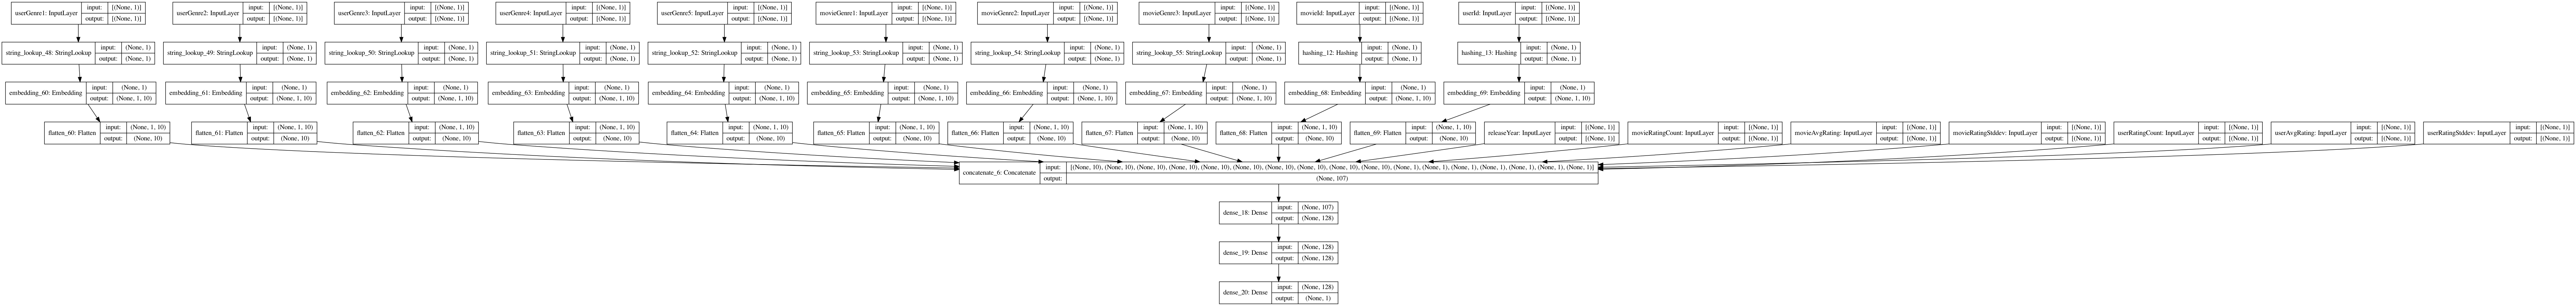

In [15]:
tf.keras.utils.plot_model(model, to_file="DeepCross.png", show_shapes=True)